### Testing FD Methods (Gauss-Seidel/Jacobi) on Different Shapes

I'm not able to get the jax functions working, wasn't able to figure out how to handle compiling conditional statements for the mask

In [2]:
import jax.numpy as jnp
from jax import Array

def init_rectangle(nx: int, ny: int, boundaries: Array | None = None) -> Array:
    """
    Initialize the solution matrix with the boundary values.

    Args:
        nx: number of grid points in x direction
        ny: number of grid points in y direction
        boundaries: list of boundary values [top, bottom, left, right]
    Returns:
        solution: initialized solution matrix
    """
    if boundaries is None:
        boundaries = jnp.zeros(4)
    mean_value = jnp.mean(boundaries)
    # n + 2 to include the boundary values
    solution = mean_value * jnp.ones((ny + 2, nx + 2))

    # set the boundary values
    solution = solution.at[0, :].set(boundaries[0])  # top
    solution = solution.at[-1, :].set(boundaries[1])  # bottom
    solution = solution.at[:, 0].set(boundaries[2])  # left
    solution = solution.at[:, -1].set(boundaries[3])  # right

    return solution

In [29]:
def init_Ushape(nx: int, ny: int, boundaries: Array | None = None) -> Array:
    """
    Initialize the solution matrix with the boundary values.
    Assume the 'neck' of the U is 1/4 the domain height and 1/2 domain width
    Let -1 denote out of domain values

    Args:
        nx: number of grid points in x direction
        ny: number of grid points in y direction
        boundaries: list of boundary values [top, bottom, left, right]
    Returns:
        solution: initialized solution matrix
    """
    if boundaries is None:
        boundaries = jnp.zeros(4)
    mean_value = jnp.mean(boundaries)
    # n + 2 to include the boundary values
    solution = mean_value * jnp.ones((ny + 2, nx + 2))
    mask = jnp.ones((ny + 2, nx + 2))

    # set the boundary values
    solution = solution.at[0, :].set(boundaries[0])  # top
    mask = mask.at[0, :].set(0)
    solution = solution.at[-1, :].set(boundaries[1])  # bottom
    mask = mask.at[-1, :].set(0)
    solution = solution.at[:, 0].set(boundaries[2])  # left
    mask = mask.at[:, 0].set(0)
    solution = solution.at[:, -1].set(boundaries[3])  # right
    mask = mask.at[:, -1].set(0)

    # set the U shape
    neck_yend = int(jnp.round(3*ny/4))
    neck_xstart = int(jnp.round(nx/4))
    neck_xend = int(jnp.round(3*nx/4))

    solution = solution.at[:neck_yend, neck_xstart:neck_xend].set(-100)
    mask = mask.at[:neck_yend, neck_xstart:neck_xend].set(0)
    solution = solution.at[:neck_yend, neck_xstart].set(0)
    mask = mask.at[:neck_yend, neck_xstart].set(0)
    solution = solution.at[:neck_yend, neck_xend].set(0)
    mask = mask.at[:neck_yend, neck_xend].set(0)
    solution = solution.at[neck_yend, neck_xstart:neck_xend+1].set(0)
    mask = mask.at[neck_yend, neck_xstart:neck_xend+1].set(0)

    return solution, mask

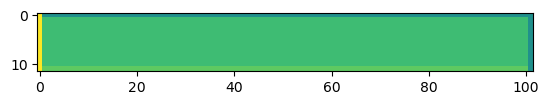

In [59]:
import matplotlib.pyplot as plt
rectangle_init = init_rectangle(100, 10, boundaries=jnp.array([0, 50, 100, 0]))

plt.imshow(rectangle_init, cmap = 'viridis', interpolation='none', vmin=-100, vmax=100)

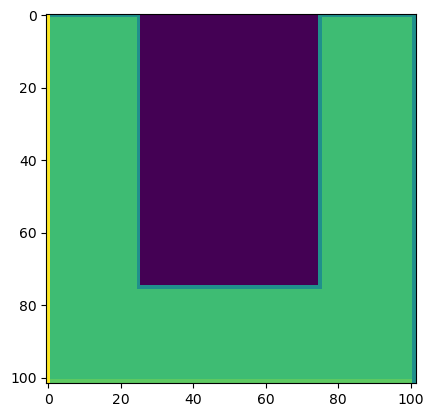

In [60]:
U_init, mask = init_Ushape(100, 100, boundaries=jnp.array([0, 50, 100, 0]))

plt.imshow(U_init, cmap = 'viridis', interpolation='none', vmin=-100, vmax=100)

In [42]:
import numpy as np 

def jacobi_np(x, n_iters=1, mask=None):
    """Jacobi method for solving an elliptic PDE."""
    n, m = x.shape
    xp = x.clone()

    for _ in range(n_iters):
        for i in range(1, n - 1):
            for j in range(1, m - 1):
                if mask is None: # if mask not provided, assume always update
                    x[i, j] = (xp[i - 1, j] + xp[i + 1, j] + xp[i, j - 1] + xp[i, j + 1]) / 4
                elif mask[i, j]: # if mask provided, only update if mask is True
                    x[i, j] = (xp[i - 1, j] + xp[i + 1, j] + xp[i, j - 1] + xp[i, j + 1]) / 4

        xp = x.clone()
    
    return x

def gauss_seidel_np(x, n_iters=1, mask=None):
    """Gauss-Seidel method for solving an elliptic PDE."""
    n, m = x.shape

    for _ in range(n_iters):
        for i in range(1, n - 1):
            for j in range(1, m - 1):
                if mask is None: # if mask not provided, assume always update
                    x[i, j] = (x[i - 1, j] + x[i + 1, j] + x[i, j - 1] + x[i, j + 1]) / 4
                elif mask[i, j]: # if mask provided, only update if mask is True
                    x[i, j] = (x[i - 1, j] + x[i + 1, j] + x[i, j - 1] + x[i, j + 1]) / 4
    
    return x

In [63]:
rectangle_init_np = np.array(rectangle_init)
rectangle_solution = gauss_seidel_np(rectangle_init_np, n_iters=2000)

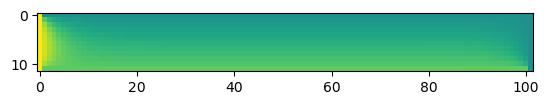

In [64]:
plt.imshow(rectangle_solution, cmap = 'viridis', interpolation='none', vmin=-100, vmax=100)

In [65]:
U_init_np = np.array(U_init)
mask_np = np.array(mask)
U_solution = gauss_seidel_np(U_init_np, n_iters=1000, mask=mask_np)

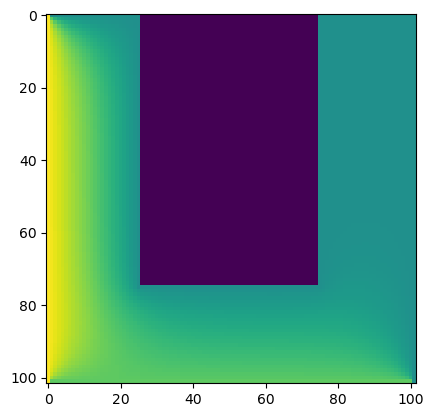

In [66]:
plt.imshow(U_solution, cmap = 'viridis', interpolation='none', vmin=-100, vmax=100)

### Matrix Methods

First use Fenics to assemble system matrix and forcing vector, then export to np array

In [76]:
from dolfin import *
import numpy as np
import matplotlib.pyplot as plt

n = 20
mesh = UnitSquareMesh(n, n)
V = FunctionSpace(mesh, "Lagrange", 1)

# Define Dirichlet boundary (x = 0 or x = 1)
def left_boundary(x):
    return x[0] < DOLFIN_EPS

def right_boundary(x):
    return x[0] > 1.0 - DOLFIN_EPS

def top_boundary(x):
    return x[1] > 1.0 - DOLFIN_EPS

def bottom_boundary(x):
    return x[1] < DOLFIN_EPS

# Define boundary condition
u0 = Constant(0.0)
uboundary = Constant(100.0)
bc_left = DirichletBC(V, uboundary, left_boundary)
bc_right = DirichletBC(V, u0, right_boundary)
bc_top = DirichletBC(V, u0, top_boundary)
bc_bottom = DirichletBC(V, u0, bottom_boundary)

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(0.0)
g = Constant(0.0)
bcs = [bc_left, bc_right, bc_top, bc_bottom]

Ak = assemble(inner(grad(u), grad(v))*dx)
L = assemble(f*v*dx + g*v*ds)

for bc in bcs:
    bc.apply(Ak, L) 

Ak_np = Ak.array()
L_np = L.get_local()

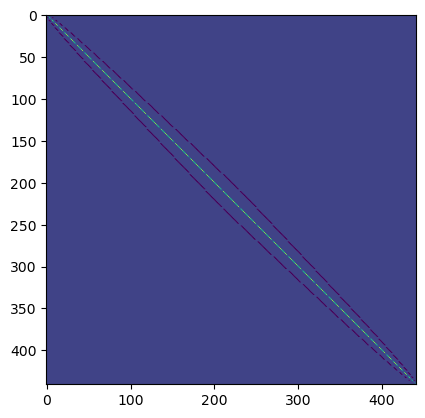

In [77]:
plt.imshow(Ak_np)

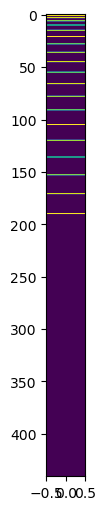

In [78]:
plt.figure(figsize=(0.5, 6))
plt.imshow(np.expand_dims(L_np, axis=1), aspect='auto')

In [83]:
import scipy 

u_np = scipy.linalg.solve(Ak_np, L_np)
print(max(u_np), min(u_np))

100.00000000000004 0.0


In [115]:
x_range = np.arange(0, 1+1/n, 1/n)
y_range = np.arange(0, 1+1/n, 1/n)

xy = np.array(np.meshgrid(x_range, y_range)).T.reshape(-1, 2)
coord_map = V.tabulate_dof_coordinates()

u_reshaped = np.zeros((n+1)*(n+1))

for i, coord in enumerate(coord_map):
    for j, xy_val in enumerate(xy):
        if np.allclose(coord, xy_val):
            u_reshaped[j] = u_np[i]

u_reshaped = u_reshaped.reshape(n+1, n+1)

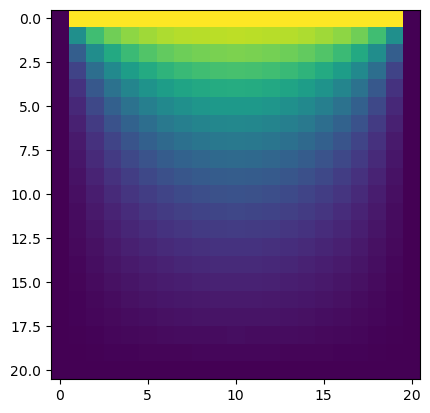

In [116]:
plt.imshow(u_reshaped)

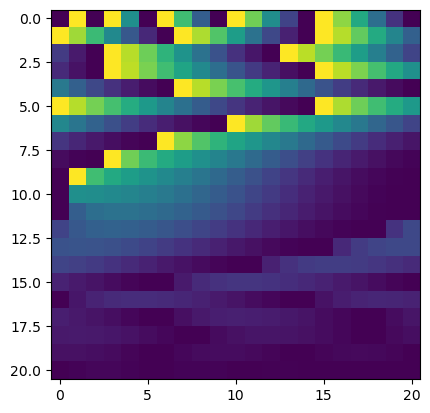

In [117]:
plt.imshow(u_np.reshape(n+1, n+1))